# experiment with random variation on encoded audio signals

process:

1. encode an audio file with an nsynth model
2. practice slight random variations on the encoding
3. decode the audio (preferably in one batch)

##### import

In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen
from numpy.random import default_rng
%matplotlib inline
%config InlineBackend.figure_format = 'jpg'

##### load the audio file

In [35]:
filename = os.path.join('in', 'iphone-ding-sound.wav')
sample_rate = 16000
length = 3
audio = utils.load_audio(filename,
                         sample_length=int(sample_rate * length),
                         sr=sample_rate)
sample_length = audio.shape[0]
print(f'{sample_length} samples, {sample_length / float(sample_rate)} seconds')


48000 samples, 3.0 seconds


##### encode the audio with nsynth

In [36]:
%%time
encoding = fastgen.encode(audio,
                          os.path.join('models', 'wavenet-ckpt', 'model.ckpt-200000'),
                          sample_length)

2022-04-21 14:24:32.491046: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 14:24:32.491684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 14:24:32.492469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 14:24:32.493249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 14:24:32.493844: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

INFO:tensorflow:Restoring parameters from models/wavenet-ckpt/model.ckpt-200000
CPU times: user 2.64 s, sys: 42.9 ms, total: 2.68 s
Wall time: 2.65 s


In [37]:
print(encoding.shape)

(1, 93, 16)


optionally save the encoded tensor

In [ ]:
np.save(
    os.path.join('npy',
                 f'{os.path.splitext(os.path.basename(filename))[0]}.npy'),
    encoding)


##### examine the audio & encoding

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(audio)
axs[0].set_title('audio signal')
axs[1].plot(encoding[0])
axs[1].set_title('nsynth encoding')

## introduce variations

for a set number of times variate slightly on the encoded matrix and concat all elements into an array for parallel decoding

### random deviation on all dimensions

In [ ]:
rng = default_rng()

copy = np.copy(encoding[0])
new_encoding = np.tile(copy, (5, 1, 1))

max_scale = 0.05 / (new_encoding.shape[0] - 1)
for i in range(new_encoding.shape[0]):
    scale = i * max_scale
    for j in range(new_encoding.shape[2]):
        vals = rng.normal(size=encoding.shape[1], scale=1)
        new_encoding[i][:, j] += vals * scale

fig, axs = plt.subplots(new_encoding.shape[0],
                        1,
                        figsize=(10, new_encoding.shape[0] * 2.5))

for i in range(new_encoding.shape[0]):
    axs[i].plot(new_encoding[i])
    axs[i].set_title(f'nsynth encoding w/ deviations of scale {i * max_scale}')


##### decode all variations and save as .wavs

In [ ]:
# generate batchwise
fastgen.synthesize(
    new_encoding,
    save_paths=[
        os.path.join(
            'out',
            f'gen_mod{i * max_scale:.4f}_{os.path.basename(filename)}'
        ) for i in range(new_encoding.shape[0])
    ],
    checkpoint_path=os.path.join('models', 'wavenet-ckpt',
                                 'model.ckpt-200000'),
    samples_per_save=sample_length)


### random deviations on some dimensions

In [ ]:
rng = default_rng()

copy = np.copy(encoding[0])
new_encoding = np.tile(copy, (new_encoding.shape[2], 1, 1))

for i in range(new_encoding.shape[0]):
    for j in range(i):
        vals = rng.normal(size=encoding.shape[1], scale=1)
        new_encoding[i][:, j] += vals * max_scale

fig, axs = plt.subplots(new_encoding.shape[0],
                        1,
                        figsize=(10, new_encoding.shape[0] * 2.5))

for i in range(new_encoding.shape[0]):
    axs[i].plot(new_encoding[i])
    axs[i].set_title(f'nsynth encoding w/ deviations on {i} axes')


##### decode all variations and save as .wavs

In [ ]:
# generate batchwise
fastgen.synthesize(
    new_encoding,
    save_paths=[
        os.path.join(
            'out',
            f'gen_mod{i}axes_{os.path.basename(filename)}'
        ) for i in range(new_encoding.shape[0])
    ],
    checkpoint_path=os.path.join('models', 'wavenet-ckpt',
                                 'model.ckpt-200000'),
    samples_per_save=sample_length)


### flattening each dimension

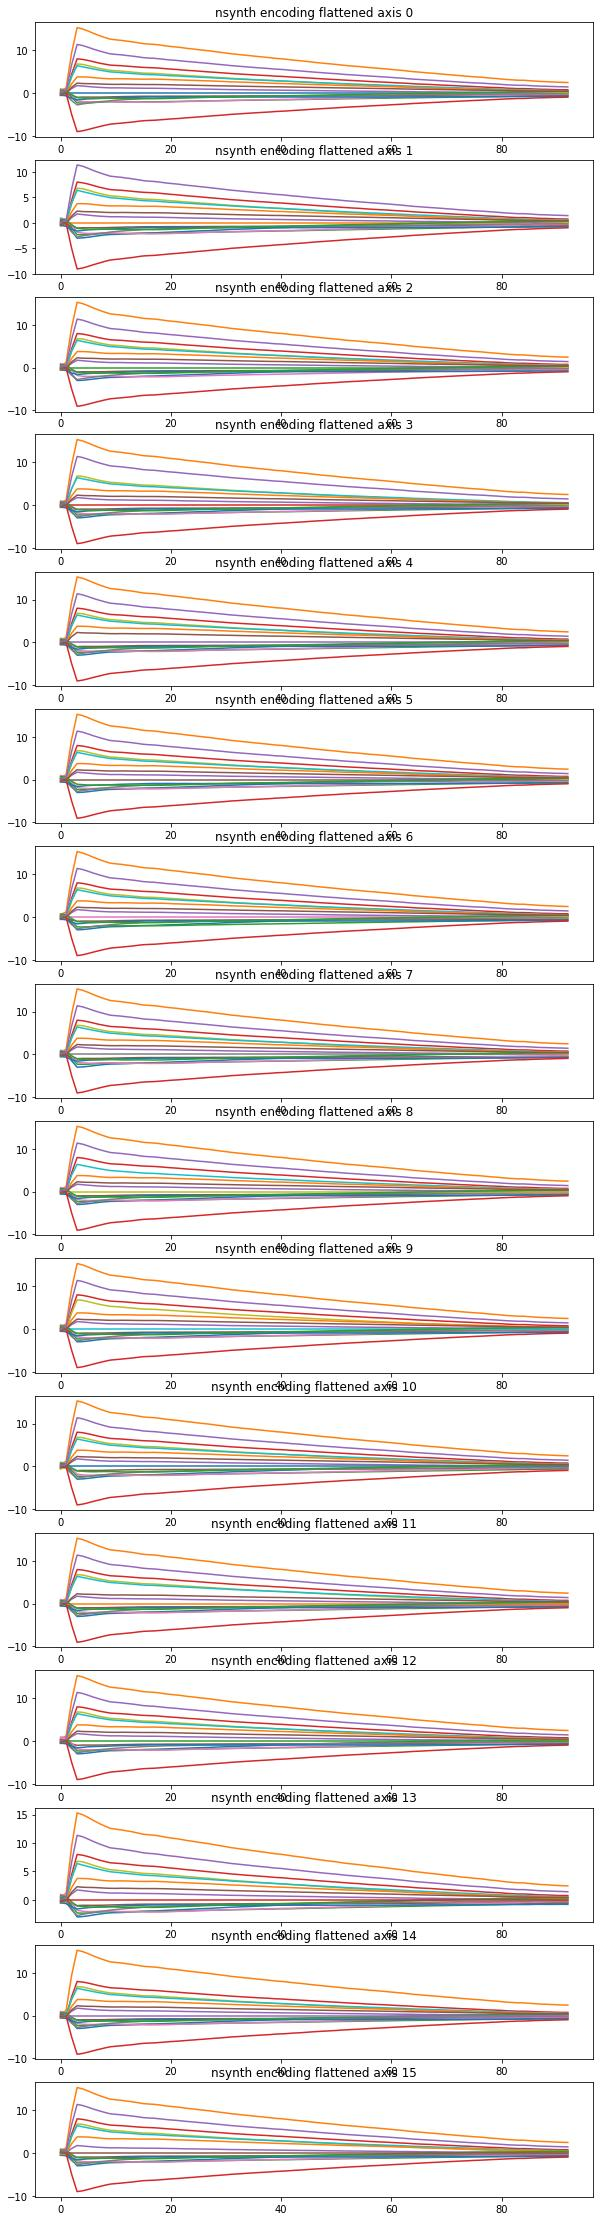

In [39]:
rng = default_rng()

copy = np.copy(encoding[0])
new_encoding = np.tile(copy, (new_encoding.shape[2], 1, 1))

axis_count = 0
for i in range(new_encoding.shape[0]):
    new_encoding[i][:, axis_count] = np.zeros(new_encoding.shape[1])
    axis_count += 1

fig, axs = plt.subplots(new_encoding.shape[0],
                        1,
                        figsize=(10, new_encoding.shape[0] * 2.5))

for i in range(new_encoding.shape[0]):
    axs[i].plot(new_encoding[i])
    axs[i].set_title(f'nsynth encoding flattened axis {i}')

##### decode all variations and save as .wavs

In [40]:
# generate batchwise
fastgen.synthesize(new_encoding,
                   save_paths=[
                       os.path.join(
                           'out',
                           f'gen_mod{i}axis_zero_{os.path.basename(filename)}')
                       for i in range(new_encoding.shape[0])
                   ],
                   checkpoint_path=os.path.join('models', 'wavenet-ckpt',
                                                'model.ckpt-200000'),
                   samples_per_save=sample_length)


2022-04-21 14:27:12.575715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 14:27:12.576294: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 14:27:12.577094: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 14:27:12.577902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-21 14:27:12.578416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

INFO:tensorflow:Restoring parameters from models/wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: out/gen_mod0axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod1axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod2axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod3axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod4axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod5axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod6axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod7axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod8axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod9axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod10axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod11axis_zero_iphone-ding-sound.wav
INFO:tensorflow:Saving: out/gen_mod12axis_zero_iphone-ding-sound.wav
INFO:te

### rampup in some dimensions

### losing certain dimensions